## Importing Dependencies

In [ ]:
!pip install gymnasium

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gymnasium as gym
from IPython.display import HTML, display

## Creating the FrozenLake Environment

This section creates the FrozenLake environment from Gymnasium, a 4x4 grid world where an agent has to navigate through a grid to reach the goal.

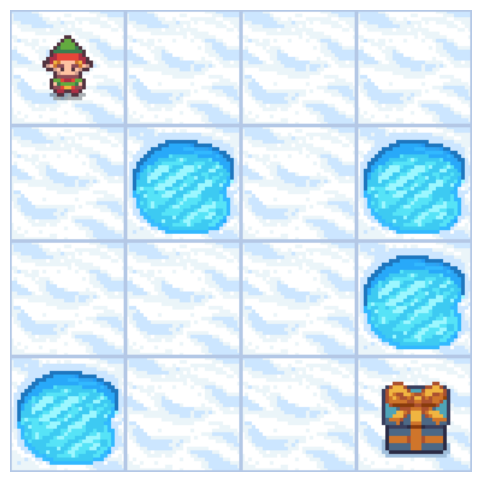

In [2]:
env = gym.make('FrozenLake-v1', map_name=f'4x4', is_slippery=False, render_mode='rgb_array')
n_states = env.observation_space.n
n_actions = env.action_space.n
nrow, ncol = env.unwrapped.desc.shape

np.random.seed(42)
env.reset(seed=42)
plt.figure(figsize=(6, 6))
plt.imshow(env.render())
plt.axis('off')
plt.show()

## Value Iteration Algorithm Implementation

This section implements the value iteration algorithm, iteratively updating the state values until convergence.

In [3]:
def value_iteration(env, num_iters=1000, gamma=0.9, epsilon=1e-6):
    V = np.zeros(n_states)
    value_changes = []

    for i in range(num_iters):
        delta = 0
        value_changes.append((i, V.copy()))
        V_old = np.copy(V)
        for s in range(n_states):
            action_values = np.zeros(n_actions)
            for a in range(n_actions):
                for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                    action_values[a] += prob * (reward + gamma * V_old[next_state] * (1 - done))
            V[s] = np.max(action_values)
            delta = max(delta, abs(V_old[s] - V[s]))
        if delta < epsilon:
            print(f'Value iteration converged at iteration {i + 1}')
            break

    return V, value_changes

## Policy Iteration Algorithm Implementation

This section implements the policy iteration algorithm, consisting of two steps: policy evaluation and policy improvement, which are repeated until the policy stabilizes.

In [4]:
def policy_iteration(env, num_iters=1000, gamma=0.9, epsilon=1e-6):
    policy = np.zeros(n_states, dtype=int)
    V = np.zeros(n_states)
    policy_changes = []
    value_changes = []

    for i in range(num_iters):
        value_changes.append((i, V.copy()))
        policy_changes.append((i, policy.copy()))

        # Policy Evaluation
        while True:
            delta = 0
            V_old = V.copy()
            for s in range(n_states):
                v = 0
                for prob, next_state, reward, done in env.unwrapped.P[s][policy[s]]:
                    v += prob * (reward + gamma * V_old[next_state] * (1 - done))
                V[s] = v
                delta = max(delta, abs(V_old[s] - V[s]))
            if delta < epsilon:
                break

        # Policy Improvement
        policy_stable = True
        for s in range(n_states):
            old_action = policy[s]
            action_values = np.zeros(n_actions)
            for a in range(n_actions):
                for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                    action_values[a] += prob * (reward + gamma * V[next_state] * (1 - done))
            policy[s] = np.argmax(action_values)
            if old_action != policy[s]:
                policy_stable = False

        if policy_stable:
            print(f'Policy iteration converged at iteration {i + 1}')
            break

    return V, policy, value_changes, policy_changes

### Running Value Iteration and Policy Iteration

This section runs both the value iteration and policy iteration algorithms, obtaining the value functions and policies for both methods.

In [5]:
# Value Iteration
V_vi, value_changes_vi = value_iteration(env)

# Policy Iteration
V_pi, policy_pi, value_changes_pi, policy_changes_pi = policy_iteration(env)


Value iteration converged at iteration 7
Policy iteration converged at iteration 7


### Visualization Animation: Value Iteration Process

This section creates and displays an animation of the value iteration process, updating the value function at each frame.

In [6]:
fig_vi, ax_vi = plt.subplots(figsize=(6, 6))
ax_vi.axis('off')
texts = []
def update_value_iteration(frame):
    for text in texts:
        text.remove()
    texts.clear()
    i, value_map = value_changes_vi[frame]
    value_map = value_map.reshape(nrow, ncol)
    ax_vi.imshow(value_map, cmap='viridis', interpolation='nearest')
    ax_vi.set_title(f"Value Iteration - Iteration {i}")
    for (i, j), v in np.ndenumerate(value_map):
        texts.append(ax_vi.text(j + 0.25, i + 0.25, f'{v:.2f}', ha='center', va='center', fontsize=12, color='white'))
ani_vi = animation.FuncAnimation(fig_vi, update_value_iteration, frames=len(value_changes_vi), repeat=True)
plt.close(fig_vi)

display(HTML(ani_vi.to_jshtml()))

### Visualization Animation: Policy Iteration Process

This section creates and displays an animation of the policy iteration process, showing the changes in the policy at each frame.

In [7]:
fig_pi, ax_pi = plt.subplots(figsize=(6, 6))
ax_pi.axis('off')
texts = []
def update_policy_iteration(frame):
    for text in texts:
        text.remove()
    texts.clear()
    i, value_map = value_changes_pi[frame]
    _, policy_map = policy_changes_pi[frame]
    value_map = value_map.reshape(nrow, ncol)
    policy_map = policy_map.reshape(nrow, ncol)
    ax_pi.imshow(value_map, cmap='viridis', interpolation='nearest')
    for (i, j), v, in np.ndenumerate(value_map):
        action = policy_map[i, j]
        texts.append(ax_pi.text(j, i, ['←', '↓', '→', '↑'][action], ha='center', va='center', fontsize=12, color='white'))
        texts.append(ax_pi.text(j + 0.25, i + 0.25, f'{v:.2f}', ha='center', va='center', fontsize=12, color='white'))
    ax_pi.set_title(f"Policy Iteration - Iteration {frame}")
ani_pi = animation.FuncAnimation(fig_pi, update_policy_iteration, frames=len(policy_changes_pi), repeat=True)
plt.close(fig_pi)

display(HTML(ani_pi.to_jshtml()))